In [1]:
#%pip install -i https://test.pypi.org/simple --extra-index-url https://pypi.org/simple tramdag

In [2]:
import os
from tramdag import TramDagModel, TramDagConfig
import warnings
warnings.filterwarnings("ignore", module="torchvision")

In [3]:
#TramDagModel.from_directory(EXPERIMENT_DIR='exp_untrained') #Loading the model from the experiment directory

In [ ]:
cfg=TramDagConfig()
cfg.setup_configuration(EXPERIMENT_DIR='exp_traind_treament_ord') # works also without arguments, then default paths are used

Configuration already exists: exp_traind_treament_ord/configuration.json


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
np.random.seed(43)
# Ja, sag mal, X1 ist uniform verteilt zwischen 0 und 2.
# T Modelliert als logistische Regression in Abhängigkeit von x1 mit dem Koeffizienten 2. 
# x2 ist normalverteilt mit Mittelwert 0 und Standardabweichung 1.
n = 10_000
x1 = np.random.uniform(0, 2, size=(n, 1))
T = np.random.binomial(1, 1 / (1 + np.exp(-2 * x1)))
x2 = -1*T + np.random.normal(0,0.1, size=(n, 1))
y = 4*T + 2*x2 + 3*x1 + np.random.normal(0, 0.1, size=(n, 1))
df = pd.DataFrame({'x1': x1.flatten(), 'T': T.flatten(), 'x2': x2.flatten(), 'y': y.flatten()})

print(df.head())


# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

         x1  T        x2         y
0  0.230109  1 -0.970318  2.711701
1  1.218133  1 -0.981813  5.735994
2  0.266782  1 -1.133603  2.535317
3  0.481179  1 -1.133444  3.004933
4  0.654278  1 -1.156792  3.559691


In [6]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'T':'ordinal_Xc_Yo', 
            'x2':'continous',
            'y':'continous'} 

cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
T                    | ordinal_Xc_Yo   | continuous [c]                 | ordinal    [0,…,K]            
x2                   | continous       | continuous [c]                 | continuous [c]                
y                    | continous       | continuous [c]                 | continuous [c]                
---------------------------------------------------------------------------------------------------------
Configuration updated successfully at exp_traind_treamen

/home/bule/TramDag/tramdag/utils/configuration.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


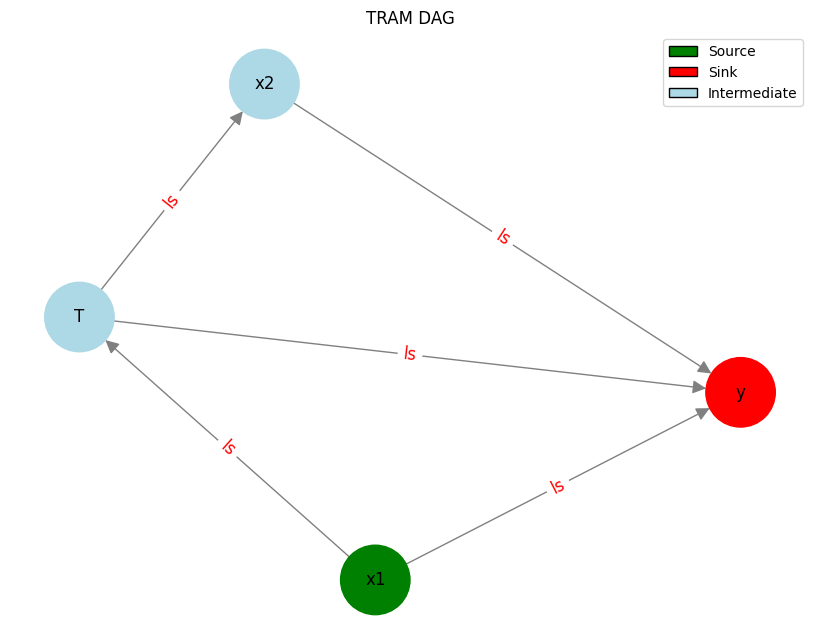

In [7]:
cfg.set_meta_adj_matrix(seed=123) #Create the (Meta) Adjacency Matrix

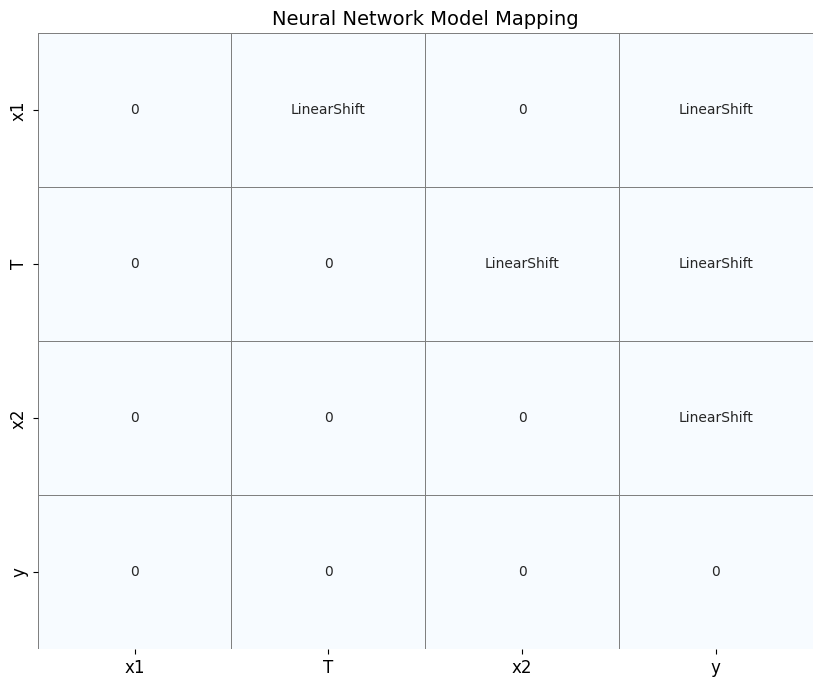

In [8]:
cfg.set_tramdag_nn_models() 
#Create the NN models one per node
# Create names for the models, which then can be to define different architectures for different nodes

All is in the configuration file now, so we delete cfg and load the configuration file

In [9]:
cfg.compute_levels(train_df)

In [10]:
from tramdag import TramDagModel
device='cpu'
td_model = TramDagModel.from_config(cfg, set_initial_weights=True,verbose=True,debug=False,device=device,initial_data =train_df )
# Created the model from the configuration
# If weight initialization is set to True then R code like Polar... is used to initialize the weights

[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=False)
)
[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=1, bias=False)
)
[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=False)
)
[INFO] Initialized intercept model with preinitialized weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=False)
)


In [32]:
epochs = 2500

td_model.fit(train_df, val_df,
#  train_list=['y'], #Training only on a subset of the model
    learning_rate=10e-2,
    epochs=epochs,batch_size=1000,
    verbose=True,debug=False,
    device=device,
    num_workers = 8,
    persistent_workers = True,
    prefetch_factor = 8,       #For DataLoader
    train_mode = "sequential") #Parallel is better for many nodes


[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to exp_traind_treament_ord/min_max_scaling.json
[INFO] Training 4 nodes (sequential) on cpu

[INFO] Training node 'x1' for 2500 epochs on cpu (pid=3242264)
[INFO] Existing model found. Loading weights and history from LAST model...

===== Epoch 2001/2500 =====


[INFO] Saved simple intercept weights for epoch 2001 -> exp_traind_treament_ord/x1/simple_intercepts_all_epochs.json
[INFO] Epoch 2001: Train NLL=0.6885 | Val NLL=0.6857 | Time=0.75s

===== Epoch 2002/2500 =====
[INFO] Saved simple intercept weights for epoch 2002 -> exp_traind_treament_ord/x1/simple_intercepts_all_epochs.json
[INFO] Epoch 2002: Train NLL=0.6883 | Val NLL=0.6864 | Time=0.28s

===== Epoch 2003/2500 =====
[INFO] Saved simple intercept weights for epoch 2003 -> exp_traind_treament_ord/x1/simple_intercepts_all_epochs.json
[INFO] Epoch 2003: Train NLL=0.6881 | Val NLL=0.6861 | Time=0.25s

===== Epoch 2004/2500 =====
[INFO] Saved simple intercept weights for epoch 2004 -> exp_traind_treament_ord/x1/simple_intercepts_all_epochs.json
[INFO] Epoch 2004: Train NLL=0.6881 | Val NLL=0.6858 | Time=0.47s

===== Epoch 2005/2500 =====
[INFO] Saved simple intercept weights for epoch 2005 -> exp_traind_treament_ord/x1/simple_intercepts_all_epochs.json
[INFO] Epoch 2005: Train NLL=0.6880

[INFO] Loaded training/validation histories for 4 nodes.


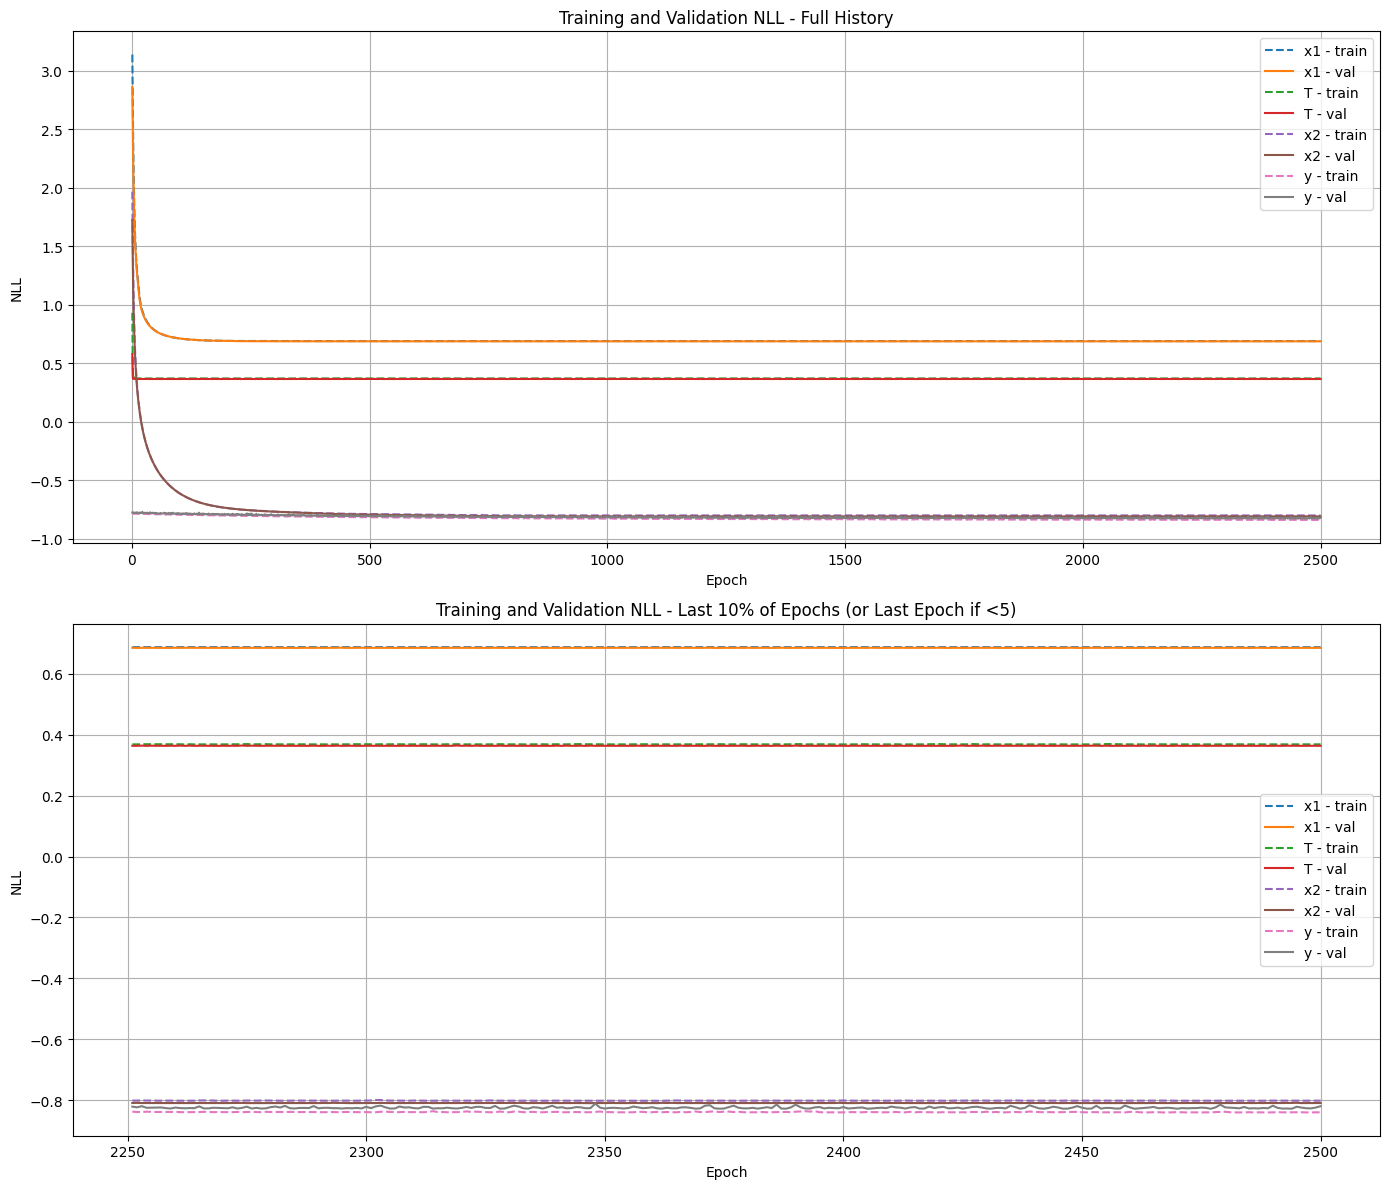

In [33]:
td_model.plot_loss_history()

[WARNING] No linear shift history found for node 'x1' at exp_traind_treament_ord/x1/linear_shifts_all_epochs.json


/home/bule/TramDag/tramdag/TramDagModel.py:1111: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(flatten)


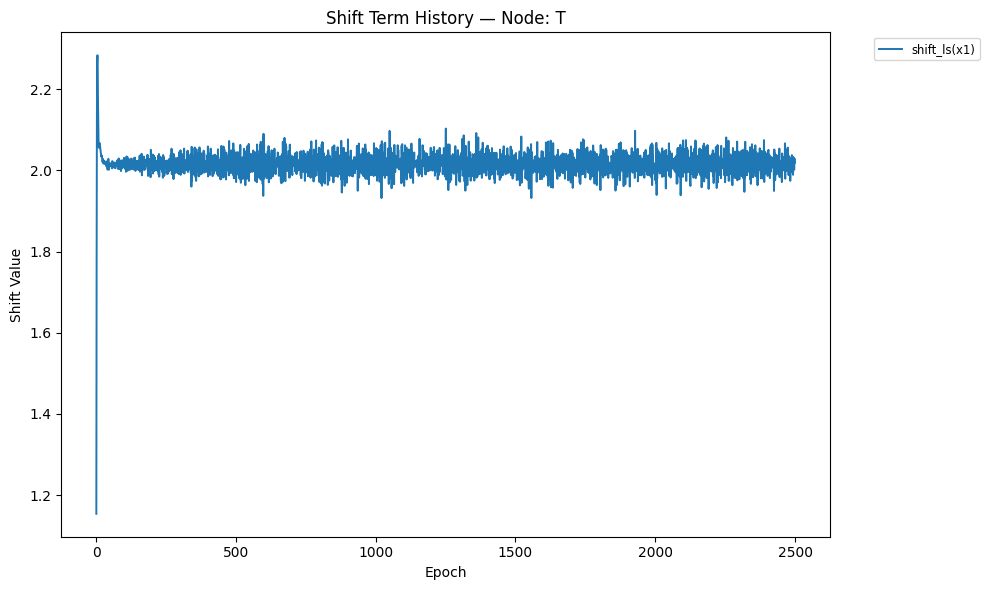

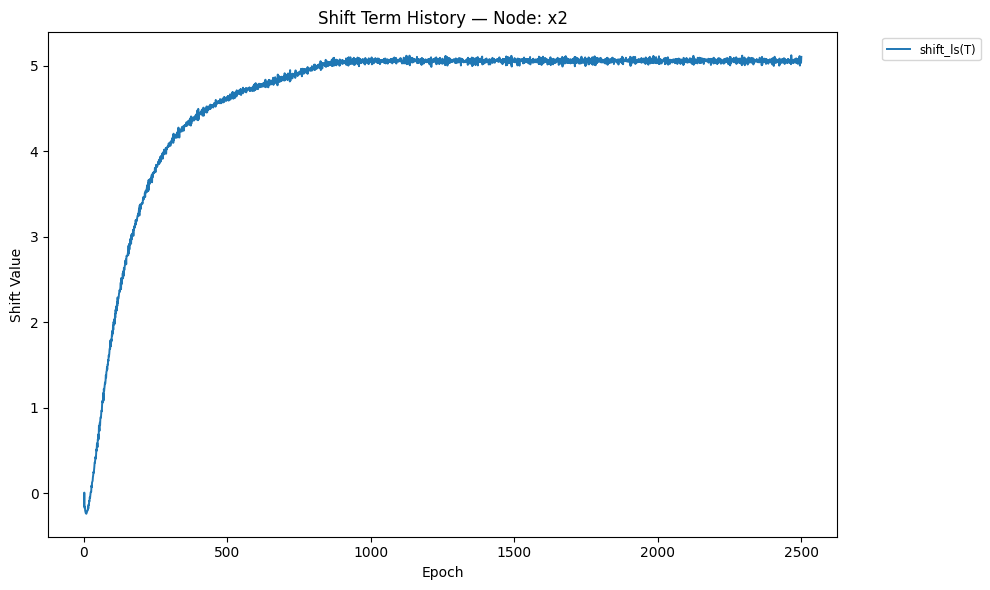

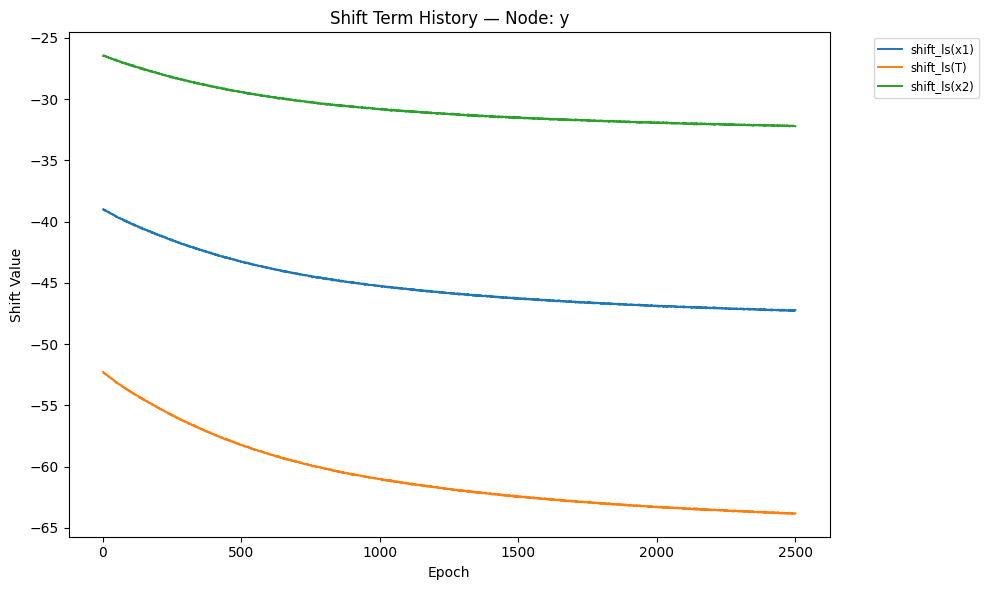

In [34]:
td_model.plot_linear_shift_history()

/home/bule/TramDag/tramdag/TramDagModel.py:1180: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


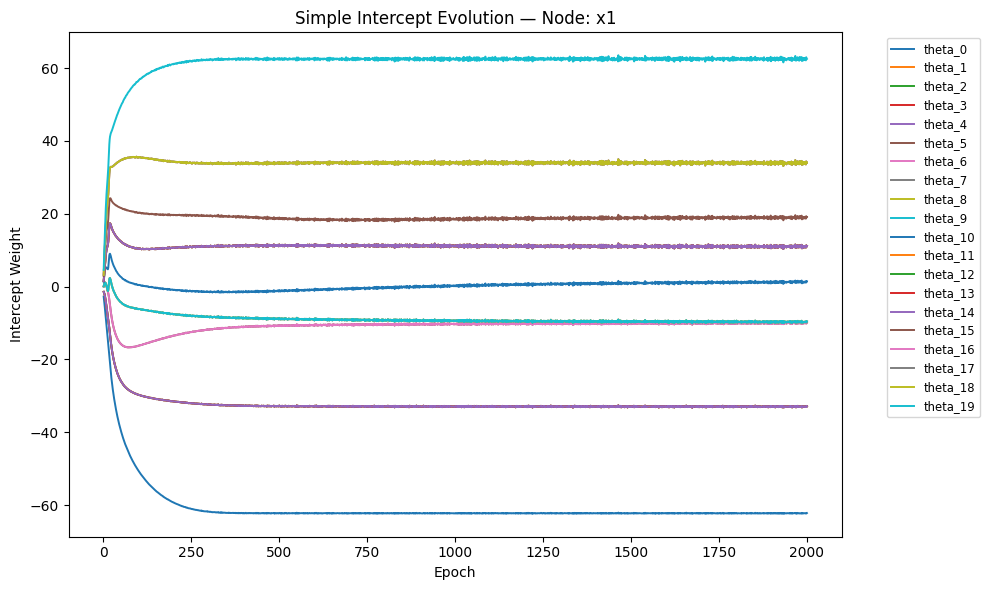

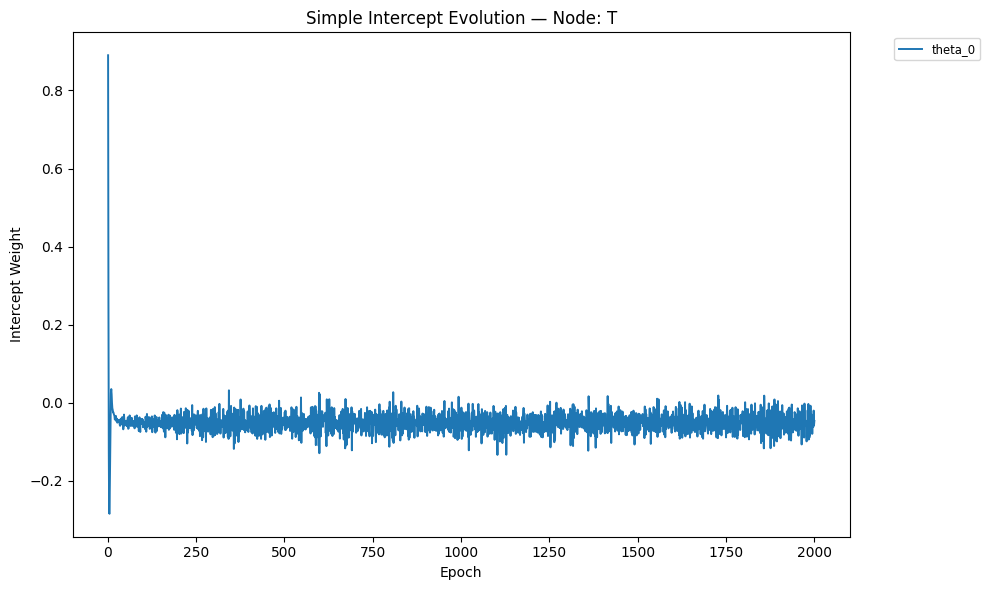

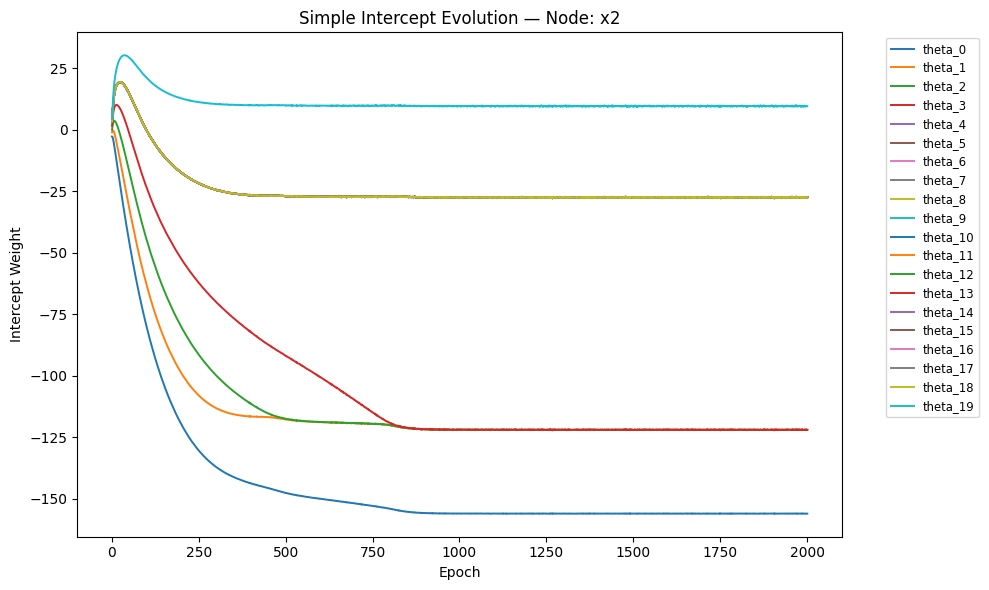

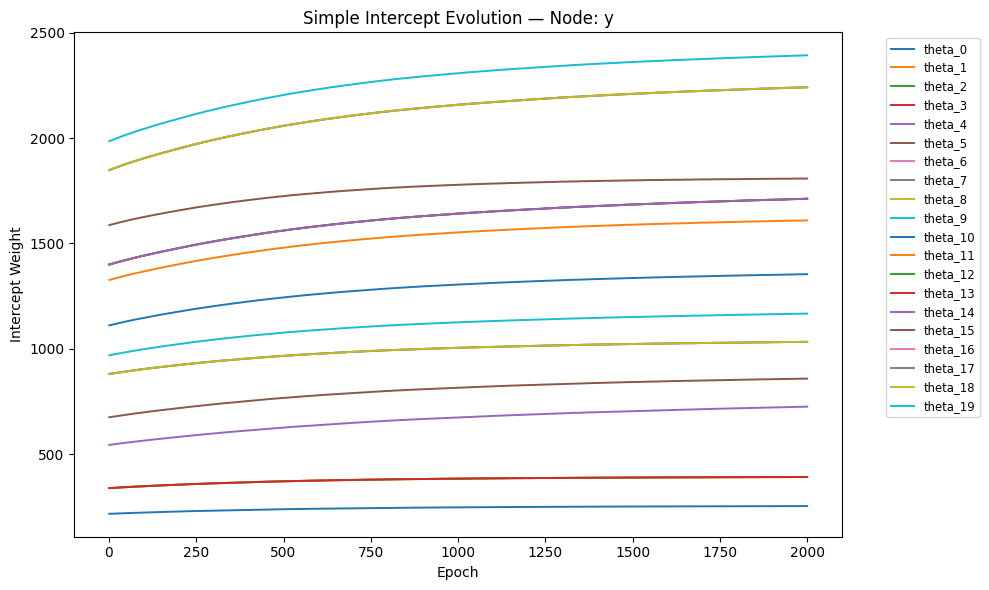

In [14]:
td_model.plot_simple_intercepts_history()

In [ ]:
# td_model.load_or_compute_minmax(train_df)
# td_model.plot_samples_vs_true(df=train_df)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to exp_traind_treament_ord/min_max_scaling.json


[INFO] Final latent DataFrame shape: (8000, 9)


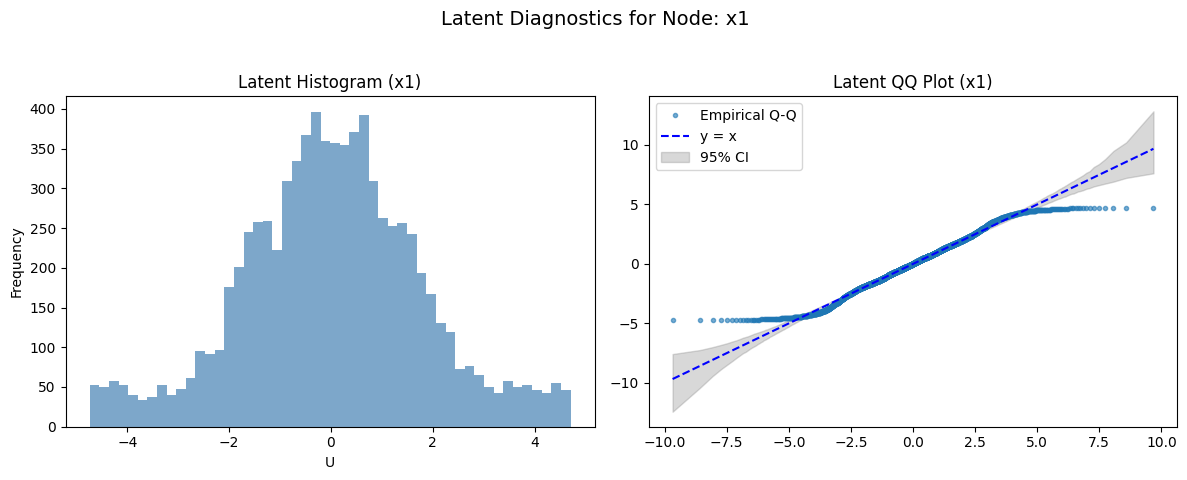

[WARNING] No latent found for node T, skipping.


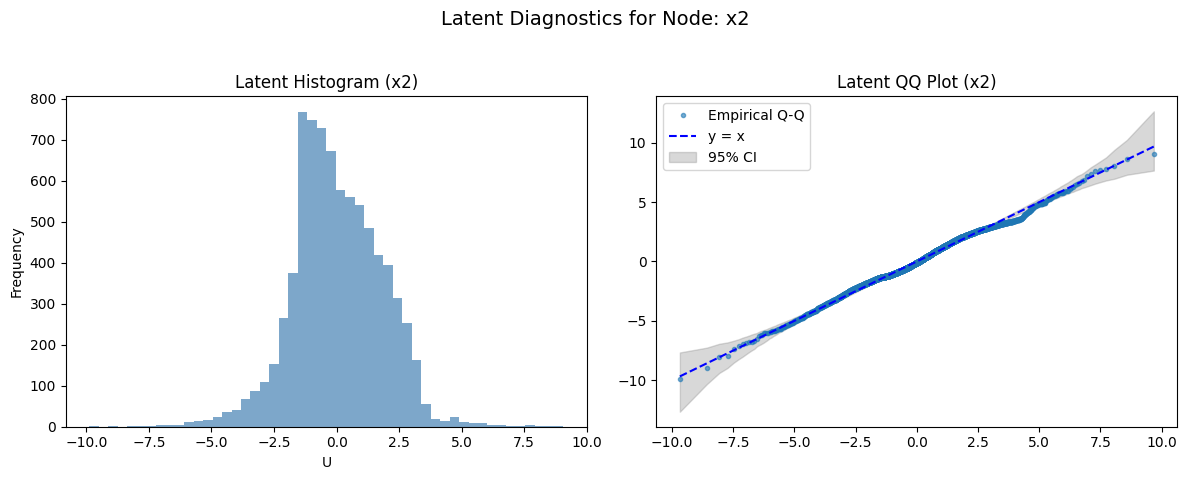

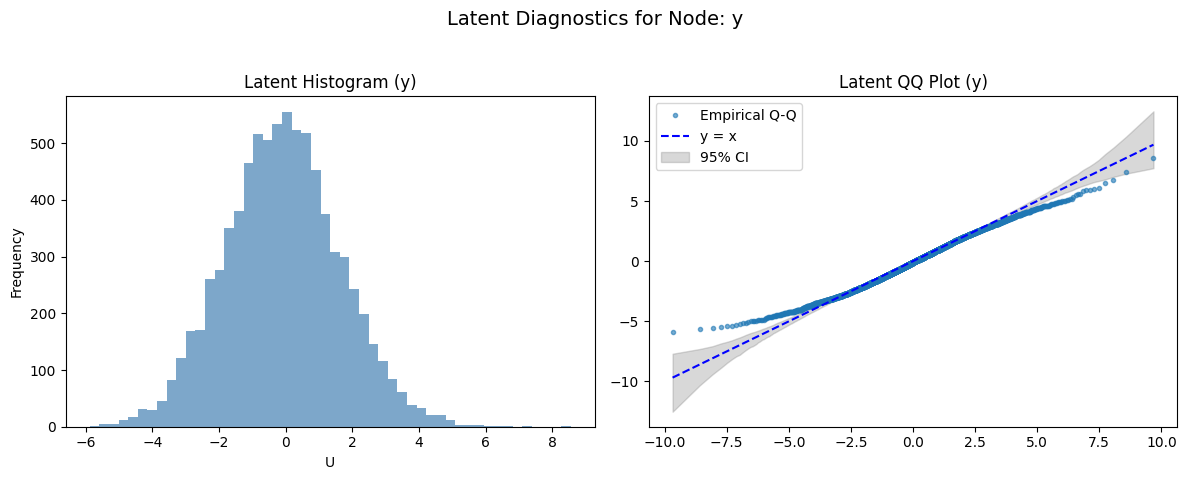

In [35]:
td_model.plot_latents(train_df)

In [20]:
u_training = td_model.get_latent(train_df)

[INFO] Final latent DataFrame shape: (8000, 9)


In [21]:
u_training.head()

,x1,x1_U,T,T_U_lower,T_U_upper,x2,x2_U,y,y_U
9254,1.796348,2.158572,1,-3.806903,inf,-0.875996,2.178250,7.534851,-2.955856
1561,1.512867,1.115135,1,-3.209245,inf,-0.975150,0.413116,6.579508,0.209732
1670,1.521291,1.139963,1,-3.227005,inf,-1.202779,-4.043862,6.241835,1.046402
6087,0.723621,-0.594710,0,-inf,-1.545292,-0.011351,-0.589083,2.155638,-0.437313
6669,1.308371,0.618262,1,-2.778110,inf,-0.965513,0.600982,6.020390,-0.244896


In [22]:
samples, latents = td_model.sample(predefined_latent_samples_df=u_training)
#samples, latents = td_model.sample()
assert(sum(latents['y'].numpy().flatten()  != np.array(u_training.y_U).flatten()),0) #check pd sucks

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 8000
[INFO] Deleting all previously sampled data.
Directory does not exist: exp_traind_treament_ord/x1/sampling
Directory does not exist: exp_traind_treament_ord/T/sampling
Directory does not exist: exp_traind_treament_ord/x2/sampling
Directory does not exist: exp_traind_treament_ord/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 57.35it/s]


[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Detected 'T_U_lower' and 'T_U_upper' — switching to counterfactual logistic sampling mode.


Sampling T:   6%|▌         | 470/8000 [01:53<30:24,  4.13it/s]


KeyboardInterrupt: 

In [ ]:
(train_df['x2']-samples['x2'].numpy().flatten())/train_df['x2']







29    -5.390176e-08
535    2.224215e-05
695   -2.552234e-06
557   -1.400964e-07
836    1.308436e-05
           ...     
106   -1.479647e-07
270    1.177148e-07
860   -6.184249e-09
435    3.935214e-05
102   -1.830173e-07
Name: x2, Length: 800, dtype: float64

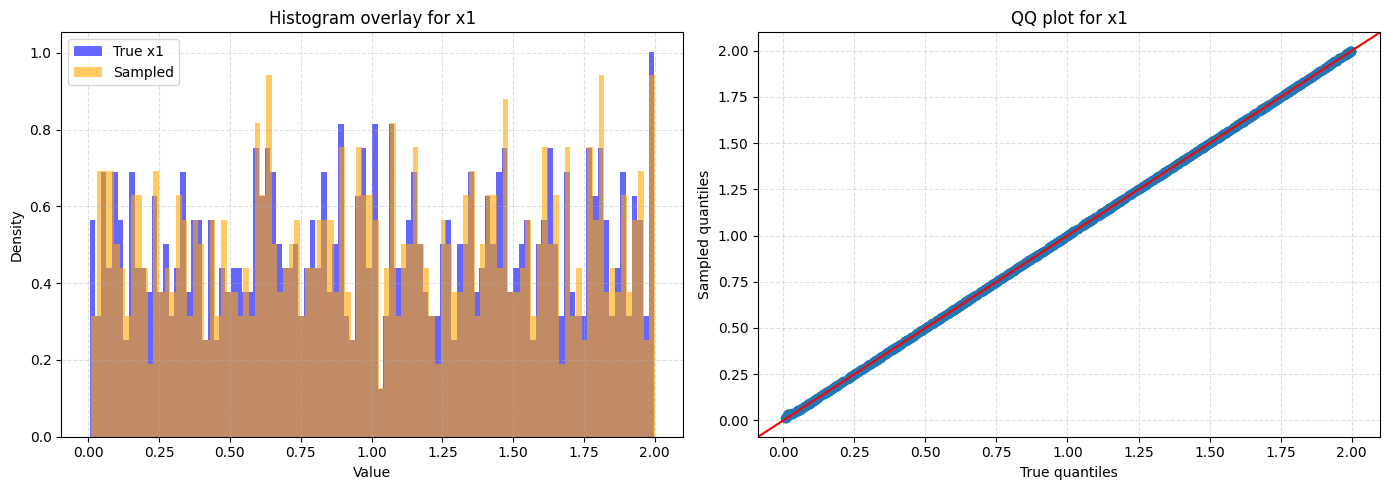

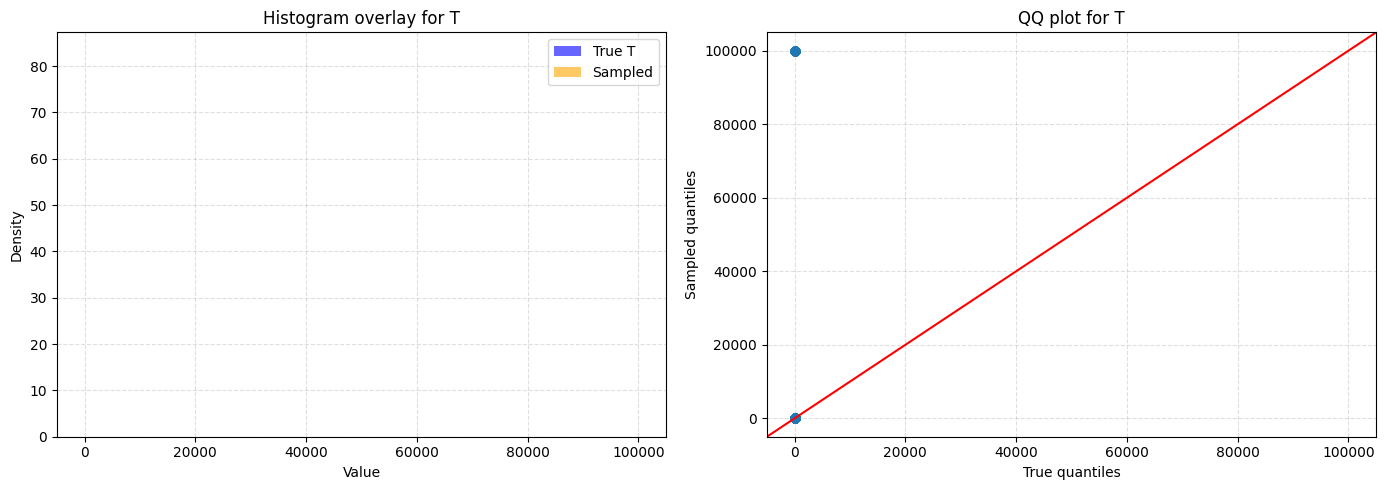

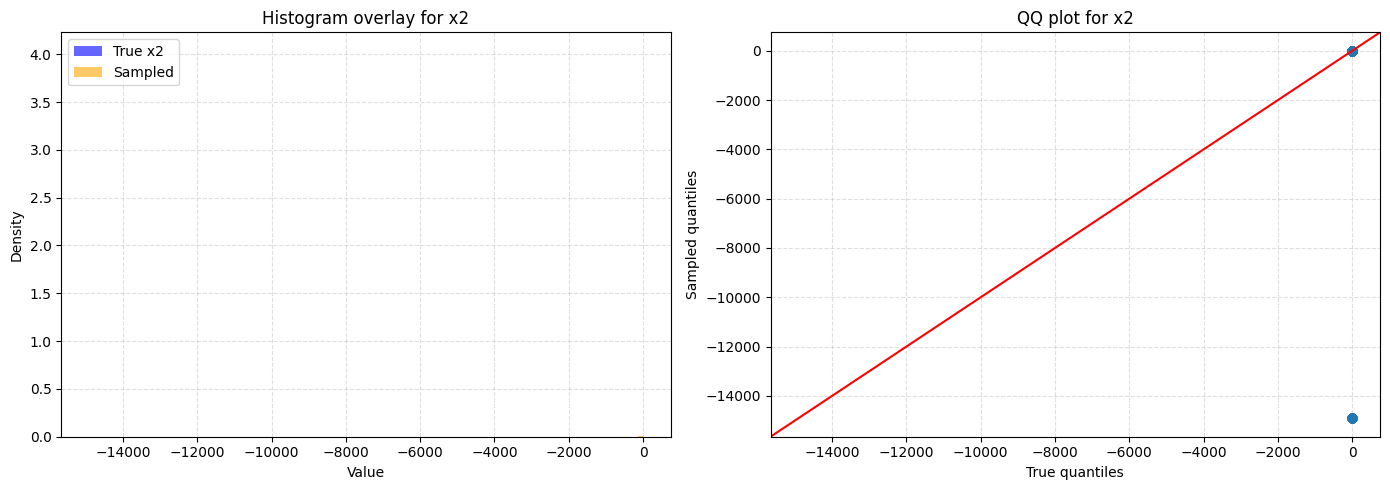

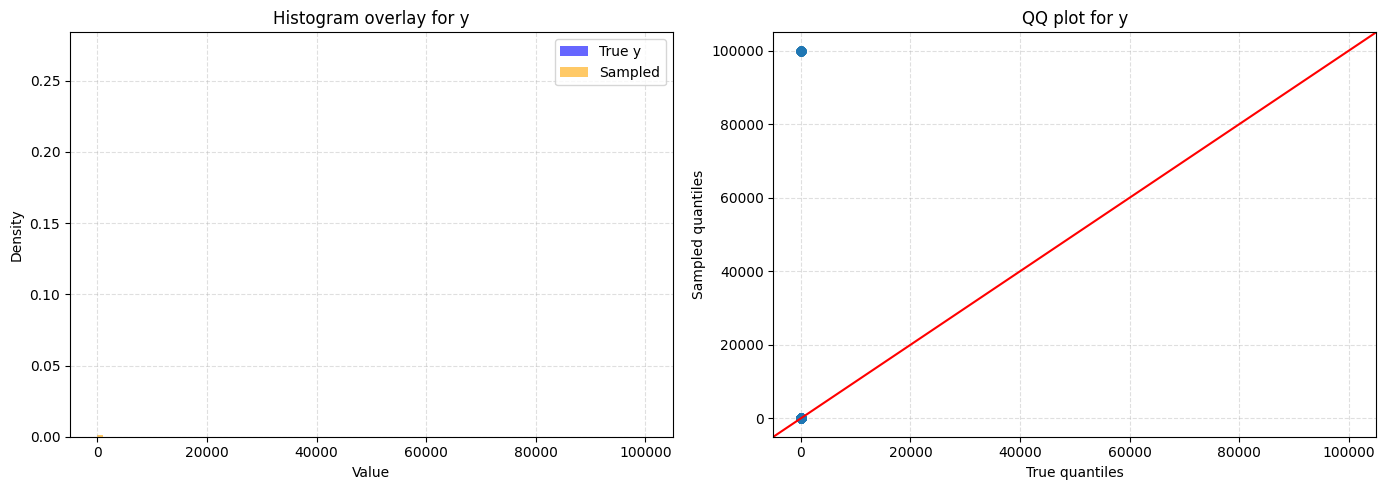

In [ ]:
td_model.plot_samples_vs_true(df=train_df, sampled=samples)

plots the DAG for the variables y using X,Y... from row=`plot_n_rows` of train df

[WARNING] len(df)>1, set: plot_n_rows accordingly
[Warning] best_model.pt not found, falling back to initial_model.pt


/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B6BD92AE-4D03-3F92-9E03-2E2594A12866> /Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extens


=== Sample 1/3 ===
x1    0.798394
T     0.000000
x2   -0.149715
y     2.052128
Name: 55, dtype: float64


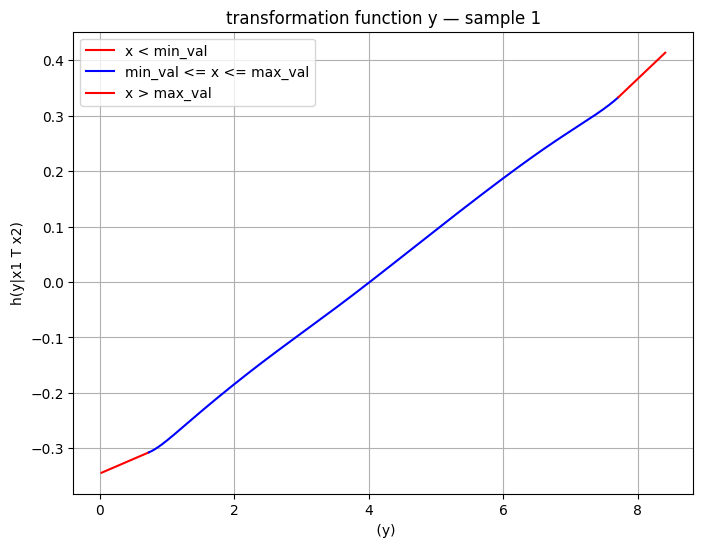


=== Sample 2/3 ===
x1    0.010167
T     0.000000
x2    0.088570
y     0.213088
Name: 88, dtype: float64


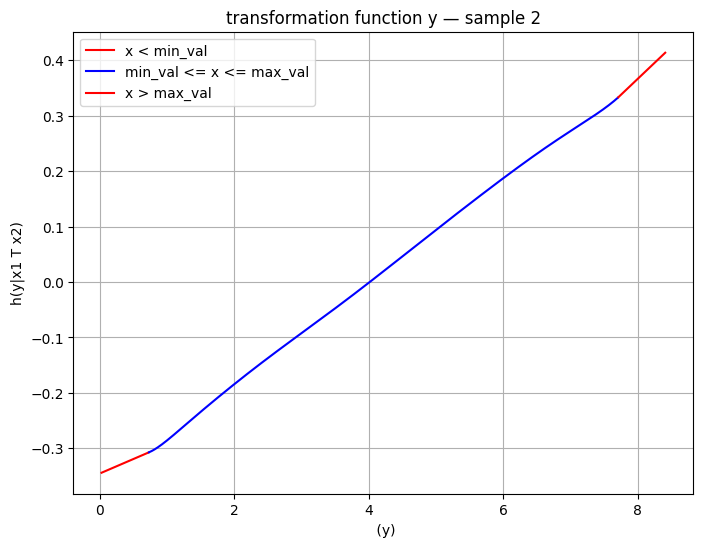


=== Sample 3/3 ===
x1    0.165000
T     0.000000
x2    0.033188
y     0.504235
Name: 26, dtype: float64


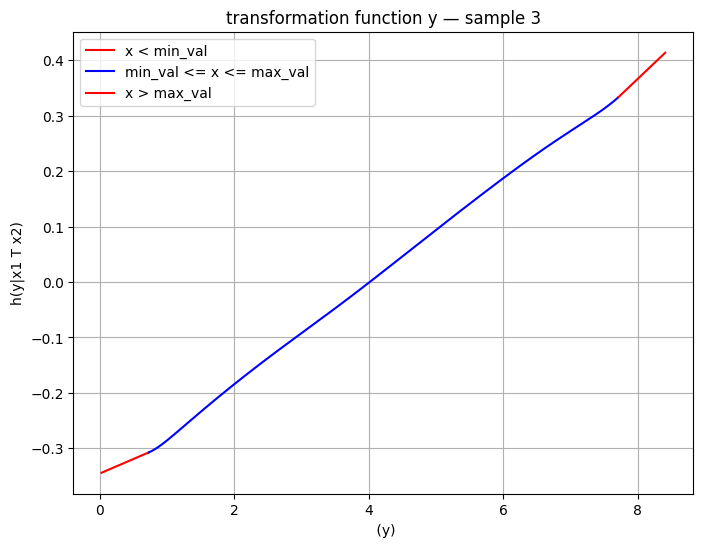

In [ ]:
td_model.plot_hdag(train_df,variables=['y'],plot_n_rows=3) 

In [ ]:
td_model.summary(verbose=True)


                                                 TRAM DAG MODEL SUMMARY                                                 

[1] TRAINING METRICS OVERVIEW
------------------------------------------------------------------------------------------------------------------------
     Node      Best Train NLL  Best Val NLL  Last Train NLL  Last Val NLL      Epochs    
      x1            None           None           None           None            0       
       T            None           None           None           None            0       
      x2            None           None           None           None            0       
       y            None           None           None           None            0       
------------------------------------------------------------------------------------------------------------------------

[2] NODE-SPECIFIC DETAILS
------------------------------------------------------------------------------------------------------------------------

      

In [ ]:
############### !!!!!!!!!!!!!!!!!!!!!!!!! #######################################################
u_training = td_model.get_latent(train_df)
samples_doT1, latents_doT1 = td_model.sample(do_interventions={'T':1.0}, predefined_latent_samples_df=u_training)
#################################################################################################

/Users/oli/Documents/GitHub/tramdag_py/.conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[INFO] Final latent DataFrame shape: (800, 8)
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['T']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 800
[INFO] Deleting all previously sampled data.
Directory does not exist: exp_untrained/x1/sampling
Directory does not exist: exp_untrained/T/sampling
Directory does not exist: exp_untrained/x2/sampling
Directory does not exist: exp_untrained/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


/Users/oli/Documents/GitHub/tramdag_py/.conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 1703.98it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'T' with value 1.0
[INFO] Interventional data for node T is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 1757.50it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 1748.22it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


$$
u2 = h(x2|T=1)
$$

$$
x2 = h^{-1}(u2|T=1)
$$

$$
x2 = h^{-1}(h(x2|T=1)|T=1)
$$


$$
uy = h(y|T=1, x1,x2) \\
y = h^{-1}(uy|T=1, x1,x2) \\
y = h^{-1}(h(y|T=1, x1,x2)|T=1, x1,x2)

$$

In [23]:
# Create a data frame from samples_doT1
samples_doT1_df = pd.DataFrame(samples_doT1)
print(samples_doT1_df.shape)
samples_doT1_df.head()
# Sahpe of samples_doT1_df
samples_doT1_df.shape, train_df.shape

# Extract the rows where T=1 from train_df and samples_doT1_df
mask = train_df['T'] == 1
train_with_T1 = train_df[mask]
samples_doT1_with_T1 = samples_doT1_df[mask.values]

train_with_T1.shape, samples_doT1_with_T1.shape
np.sum(train_with_T1['T'] == 1)
samples_doT1_with_T1['T']

NameError: name 'samples_doT1' is not defined

In [ ]:
np.mean(train_with_T1['T'] > 0.5)
samples_doT1_with_T1


,x1,T,x2,y
0,0.524610,1.0,-0.912561,4.051525
1,0.643226,1.0,-0.974298,3.857446
2,1.302257,1.0,-1.007256,5.821957
3,1.355053,1.0,-0.935367,6.113809
4,1.173581,1.0,-1.016679,5.447661
...,...,...,...,...
795,1.883126,1.0,-0.969880,7.558897
796,0.542529,1.0,-0.950423,3.751366
797,0.245113,1.0,-0.950539,3.037629
798,1.358318,1.0,-0.931408,5.949137


In [ ]:
train_with_T1['T']

29     1
535    1
695    1
557    1
836    1
      ..
106    1
270    1
860    1
435    1
102    1
Name: T, Length: 665, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

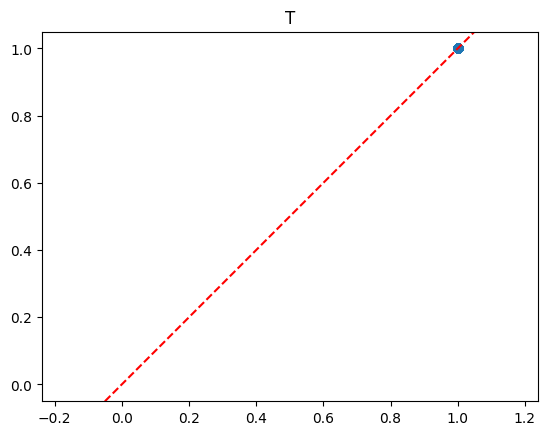

In [ ]:
plt.scatter(train_with_T1['T'], train_with_T1['T'])
plt.title('T')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')

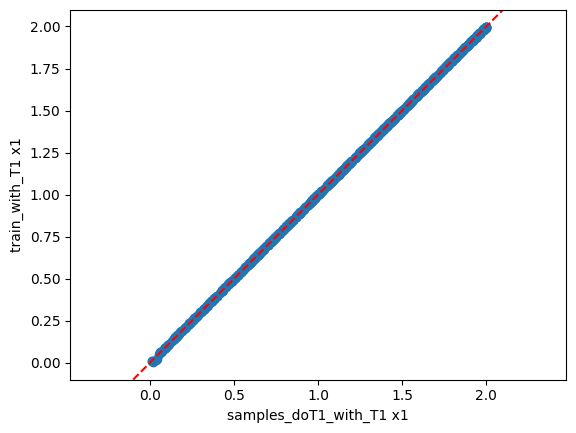

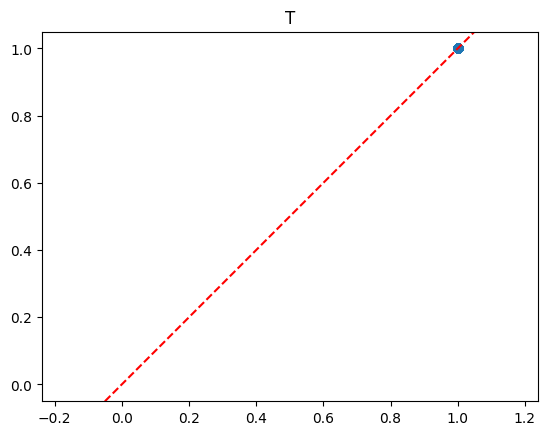

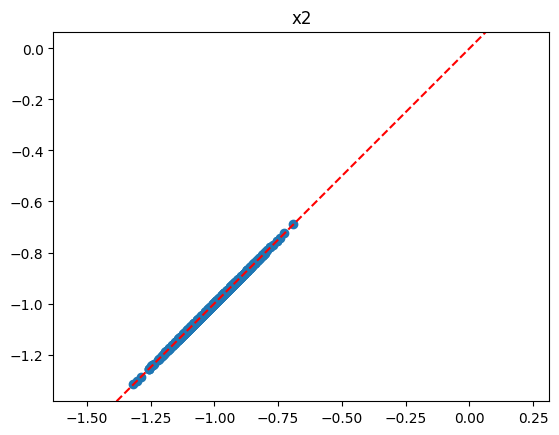

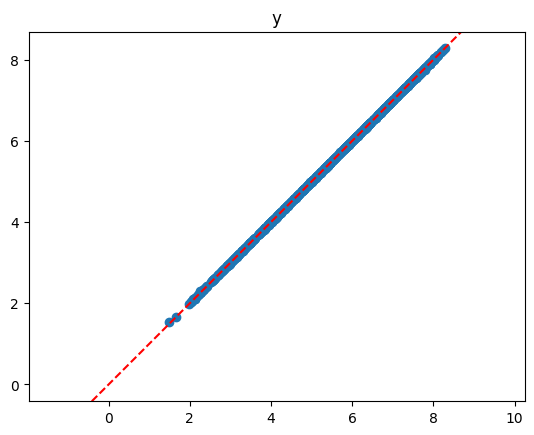

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(samples_doT1_with_T1['x1'], train_with_T1['x1'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.xlabel('samples_doT1_with_T1 x1')
plt.ylabel('train_with_T1 x1')
plt.show()


plt.scatter(train_with_T1['T'], train_with_T1['T'])
plt.title('T')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

plt.title('x2')
plt.scatter(samples_doT1_with_T1['x2'], train_with_T1['x2'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

plt.title('y')
plt.scatter(samples_doT1_with_T1['y'], train_with_T1['y'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

In [ ]:
df = np.array(test_df) #Fuck the 🐼

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### ITE vis CF 

### Train

In [ ]:
u_train_T0 = td_model.get_latent(train_df[train_df['T'] == 0])
u_train_T1 = td_model.get_latent(train_df[train_df['T'] == 1])


samples_cf_doT1, latents_doT1 = td_model.sample(do_interventions={'T':1.0}, predefined_latent_samples_df=u_train_T0)
samples_cf_doT0, latents_doT0 = td_model.sample(do_interventions={'T':0.0}, predefined_latent_samples_df=u_train_T1)

[WARNING] Ordinal 'T' has 1 unique values, expected 2. Skipping strict comparison.
[INFO] Final latent DataFrame shape: (1266, 9)
[WARNING] Ordinal 'T' has 1 unique values, expected 2. Skipping strict comparison.
[INFO] Final latent DataFrame shape: (6734, 9)
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['T']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 1266
[INFO] Deleting all previously sampled data.
Deleted directory: exp_traind_treament_ord/x1/sampling
Deleted directory: exp_traind_treament_ord/T/sampling
Deleted directory: exp_traind_treament_ord/x2/sampling
Deleted directory: exp_traind_treament_ord/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 224.55it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'T' with value 1.0
[INFO] Interventional data for node T is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 277.83it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 297.98it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['T']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 6734
[INFO] Deleting all previously sampled data.
Deleted directory: exp_traind_treament_ord/x1/sampling
Deleted directory: exp_traind_treament_ord/T/sampling
Deleted directory: exp_traind_treament_ord/x2/sampling
Deleted directory: exp_traind_treament_ord/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 68.61it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'T' with value 0.0
[INFO] Interventional data for node T is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 68.76it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 71.97it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


In [40]:
# Definition of the ITE using the counterfactuals and the factual
# ITE_i = Y(T_i=1,X_i) - Y(T_i=0,X_i) #NB one is factual, the other is counterfactual

# First for the factual T=1
Y_factual_T1 = train_df[train_df['T'] == 1]['y']
# Counterfactual T=0
Y_counterfactual_T0 = samples_cf_doT0['y'].numpy().flatten()

# ITE_i = Y(T_i=1,X_i) - Y(T_i=0,X_i)
ITE = Y_factual_T1 - Y_counterfactual_T0
print("Factual T1 ITE.mean()",ITE.mean())

Y_factual_T0 = test_df[test_df['T'] == 0]['y']
Y_counterfactual_T1 = samples_cf_doT1['y'].numpy().flatten()
ITE_T0 = Y_counterfactual_T1 - Y_factual_T0
print("Factual T0 ITE.mean()",ITE_T0.mean())

Factual T1 ITE.mean() 2.3007998826726275


ValueError: operands could not be broadcast together with shapes (1266,) (168,) 

### TEST

In [36]:
u_test_T0 = td_model.get_latent(test_df[test_df['T'] == 0])
u_test_T1 = td_model.get_latent(test_df[test_df['T'] == 1])


samples_cf_doT1, latents_doT1 = td_model.sample(do_interventions={'T':1.0}, predefined_latent_samples_df=u_test_T0)
samples_cf_doT0, latents_doT0 = td_model.sample(do_interventions={'T':0.0}, predefined_latent_samples_df=u_test_T1)

[WARNING] Ordinal 'T' has 1 unique values, expected 2. Skipping strict comparison.
[INFO] Final latent DataFrame shape: (168, 9)
[WARNING] Ordinal 'T' has 1 unique values, expected 2. Skipping strict comparison.
[INFO] Final latent DataFrame shape: (832, 9)
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['T']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 168
[INFO] Deleting all previously sampled data.
Deleted directory: exp_traind_treament_ord/x1/sampling
Deleted directory: exp_traind_treament_ord/T/sampling
Deleted directory: exp_traind_treament_ord/x2/sampling
Deleted directory: exp_traind_treament_ord/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 676.75it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'T' with value 1.0
[INFO] Interventional data for node T is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 790.12it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 737.12it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['T']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 832
[INFO] Deleting all previously sampled data.
Deleted directory: exp_traind_treament_ord/x1/sampling
Deleted directory: exp_traind_treament_ord/T/sampling
Deleted directory: exp_traind_treament_ord/x2/sampling
Deleted directory: exp_traind_treament_ord/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 311.76it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'T' with value 0.0
[INFO] Interventional data for node T is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 388.84it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 326.55it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


### Test

In [39]:
# Definition of the ITE using the counterfactuals and the factual
# ITE_i = Y(T_i=1,X_i) - Y(T_i=0,X_i) #NB one is factual, the other is counterfactual

# First for the factual T=1
Y_factual_T1 = test_df[test_df['T'] == 1]['y']
# Counterfactual T=0
Y_counterfactual_T0 = samples_cf_doT0['y'].numpy().flatten()

# ITE_i = Y(T_i=1,X_i) - Y(T_i=0,X_i)
ITE = Y_factual_T1 - Y_counterfactual_T0
print("Factual T1 ITE.mean()",ITE.mean())

Y_factual_T0 = test_df[test_df['T'] == 0]['y']
Y_counterfactual_T1 = samples_cf_doT1['y'].numpy().flatten()
ITE_T0 = Y_counterfactual_T1 - Y_factual_T0
print("Factual T0 ITE.mean()",ITE_T0.mean())

ValueError: operands could not be broadcast together with shapes (832,) (6734,) 